Xây dựng hệ thống hỗ trợ ra quyết định phê duyệt khoản vay

Mục tiêu: Phát triển một mô hình DSS giúp đánh giá khả năng phê duyệt khoản vay dựa trên các yếu tố như thu nhập, điểm tín dụng (CIBIL), tài sản, trình độ học vấn, v.v.

Phương pháp:
- Phân tích dữ liệu bằng các thuật toán học máy (Machine Learning), Random Forest, v.v.
-	Đánh giá độ chính xác của hệ thống.


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sb 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# 1. Đọc dữ liệu

In [2]:
import pandas as pd

# Đọc dữ liệu từ file CSV
df = pd.read_csv('Data/loan_approval_dataset.csv')

df.head()


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


* trong đó:
    + Loan_ id: số thứ tự id của mỗi khách hàng -> id này không được giống nhau, mỗi khách hàng cần có 1 id riêng biệt và là số nguyên, không được âm
    + no_of_dependents: số người phụ thuộc ( là số người phụ thuộc vào khách hàng): là số nguyên, không được âm
    + education: tình trạng tốt nghiệp của người vay, không được là số dạng string
    + self_employed: trạng thái việc làm của khách hàng làm chủ hay không làm chủ
    + income_annum: thu thập hàng năm của khách hàng, là số dương
    + loan_amount : số tiền vay, là số dương < giả sử là đô la Mỹ>
    + loan_term : thời hạn vay ( đơn vị: năm)
    + cibil_score: điểm tín dụng
    + residential_assets_value: giá trị tài sản nhà ở 
    + commercial_assets_value: giá trị tài sản thương mại < là số tiền tất cả tài sản của khách hàng hiện có> 
    + luxury_assets_value: giá trị tài sản xa xỉ
    + bank_asset_value: giá trị tài sản ngân hàng
    + loan_status: trạng thái phê duyệt khoản vay 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


# 2. Tiền xử lý dữ liệu

### 2.1.1.Kiểm tra dữ liệu trùng lặp, thiếu

In [4]:
# xử lý các hàng trùng lặp
print('Số hàng trùng lặp:', df.duplicated().sum())
print('Số lượng hàng và cột ban đầu:', df.shape)

df.drop_duplicates(inplace=True)

print('Số lượng hàng và cột sau khi xóa trùng lặp:', df.shape)


Số hàng trùng lặp: 0
Số lượng hàng và cột ban đầu: (4269, 13)
Số lượng hàng và cột sau khi xóa trùng lặp: (4269, 13)


Không có dữ liệu trùng lặp

In [5]:
# Kiểm tra các dữ liệu thiếu
df.describe(include='O')

,education,self_employed,loan_status
count,4269,4269,4269
unique,2,2,2
top,Graduate,Yes,Approved
freq,2144,2150,2656


Không có dữ liệu nào bị thiếu

### 2.1.2. Xử lý lỗi cấu trúc

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


Chuyển đổi đơn vị tiền tệ từ INR sang USD

Tỷ giá: 1 USD = 83 INR

Tạo 6 cột mới để thay thế:

In [7]:
d = df.columns.tolist()
print(d)

['loan_id', ' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']


In [8]:
usd_conversion_rate = 83

df["income_annum_usd"] = df[" income_annum"] / usd_conversion_rate
df["loan_amount_usd"] = df[" loan_amount"] / usd_conversion_rate
df["residential_assets_usd"] = df[" residential_assets_value"] / usd_conversion_rate
df["commercial_assets_usd"] = df[" commercial_assets_value"] / usd_conversion_rate
df["luxury_assets_usd"] = df[" luxury_assets_value"] / usd_conversion_rate
df["bank_assets_usd"] = df[" bank_asset_value"] / usd_conversion_rate

# Xoá các cột cũ (INR)
cols_to_drop = [
    " income_annum", " loan_amount", " residential_assets_value",
    " commercial_assets_value", " luxury_assets_value", " bank_asset_value"
]
df = df.drop(columns=cols_to_drop)
df

,loan_id,no_of_dependents,education,self_employed,loan_term,cibil_score,loan_status,income_annum_usd,loan_amount_usd,residential_assets_usd,commercial_assets_usd,luxury_assets_usd,bank_assets_usd
0,1,2,Graduate,No,12,778,Approved,115662.650602,360240.963855,28915.662651,212048.192771,273493.975904,96385.542169
1,2,0,Not Graduate,Yes,8,417,Rejected,49397.590361,146987.951807,32530.120482,26506.024096,106024.096386,39759.036145
2,3,3,Graduate,No,20,506,Rejected,109638.554217,357831.325301,85542.168675,54216.867470,401204.819277,154216.867470
3,4,3,Graduate,No,8,467,Rejected,98795.180723,369879.518072,219277.108434,39759.036145,280722.891566,95180.722892
4,5,5,Not Graduate,Yes,20,382,Rejected,118072.289157,291566.265060,149397.590361,98795.180723,354216.867470,60240.963855
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,4265,5,Graduate,Yes,12,317,Rejected,12048.192771,27710.843373,33734.939759,6024.096386,39759.036145,9638.554217
4265,4266,0,Not Graduate,Yes,20,559,Approved,39759.036145,136144.578313,50602.409639,34939.759036,132530.120482,22891.566265
4266,4267,2,Not Graduate,No,18,457,Rejected,78313.253012,287951.807229,14457.831325,149397.590361,218072.289157,87951.807229
4267,4268,1,Not Graduate,No,8,780,Approved,49397.590361,154216.867470,98795.180723,8433.734940,169879.518072,69879.518072


### 2.1.3 Xử lý Ngoại lệ 

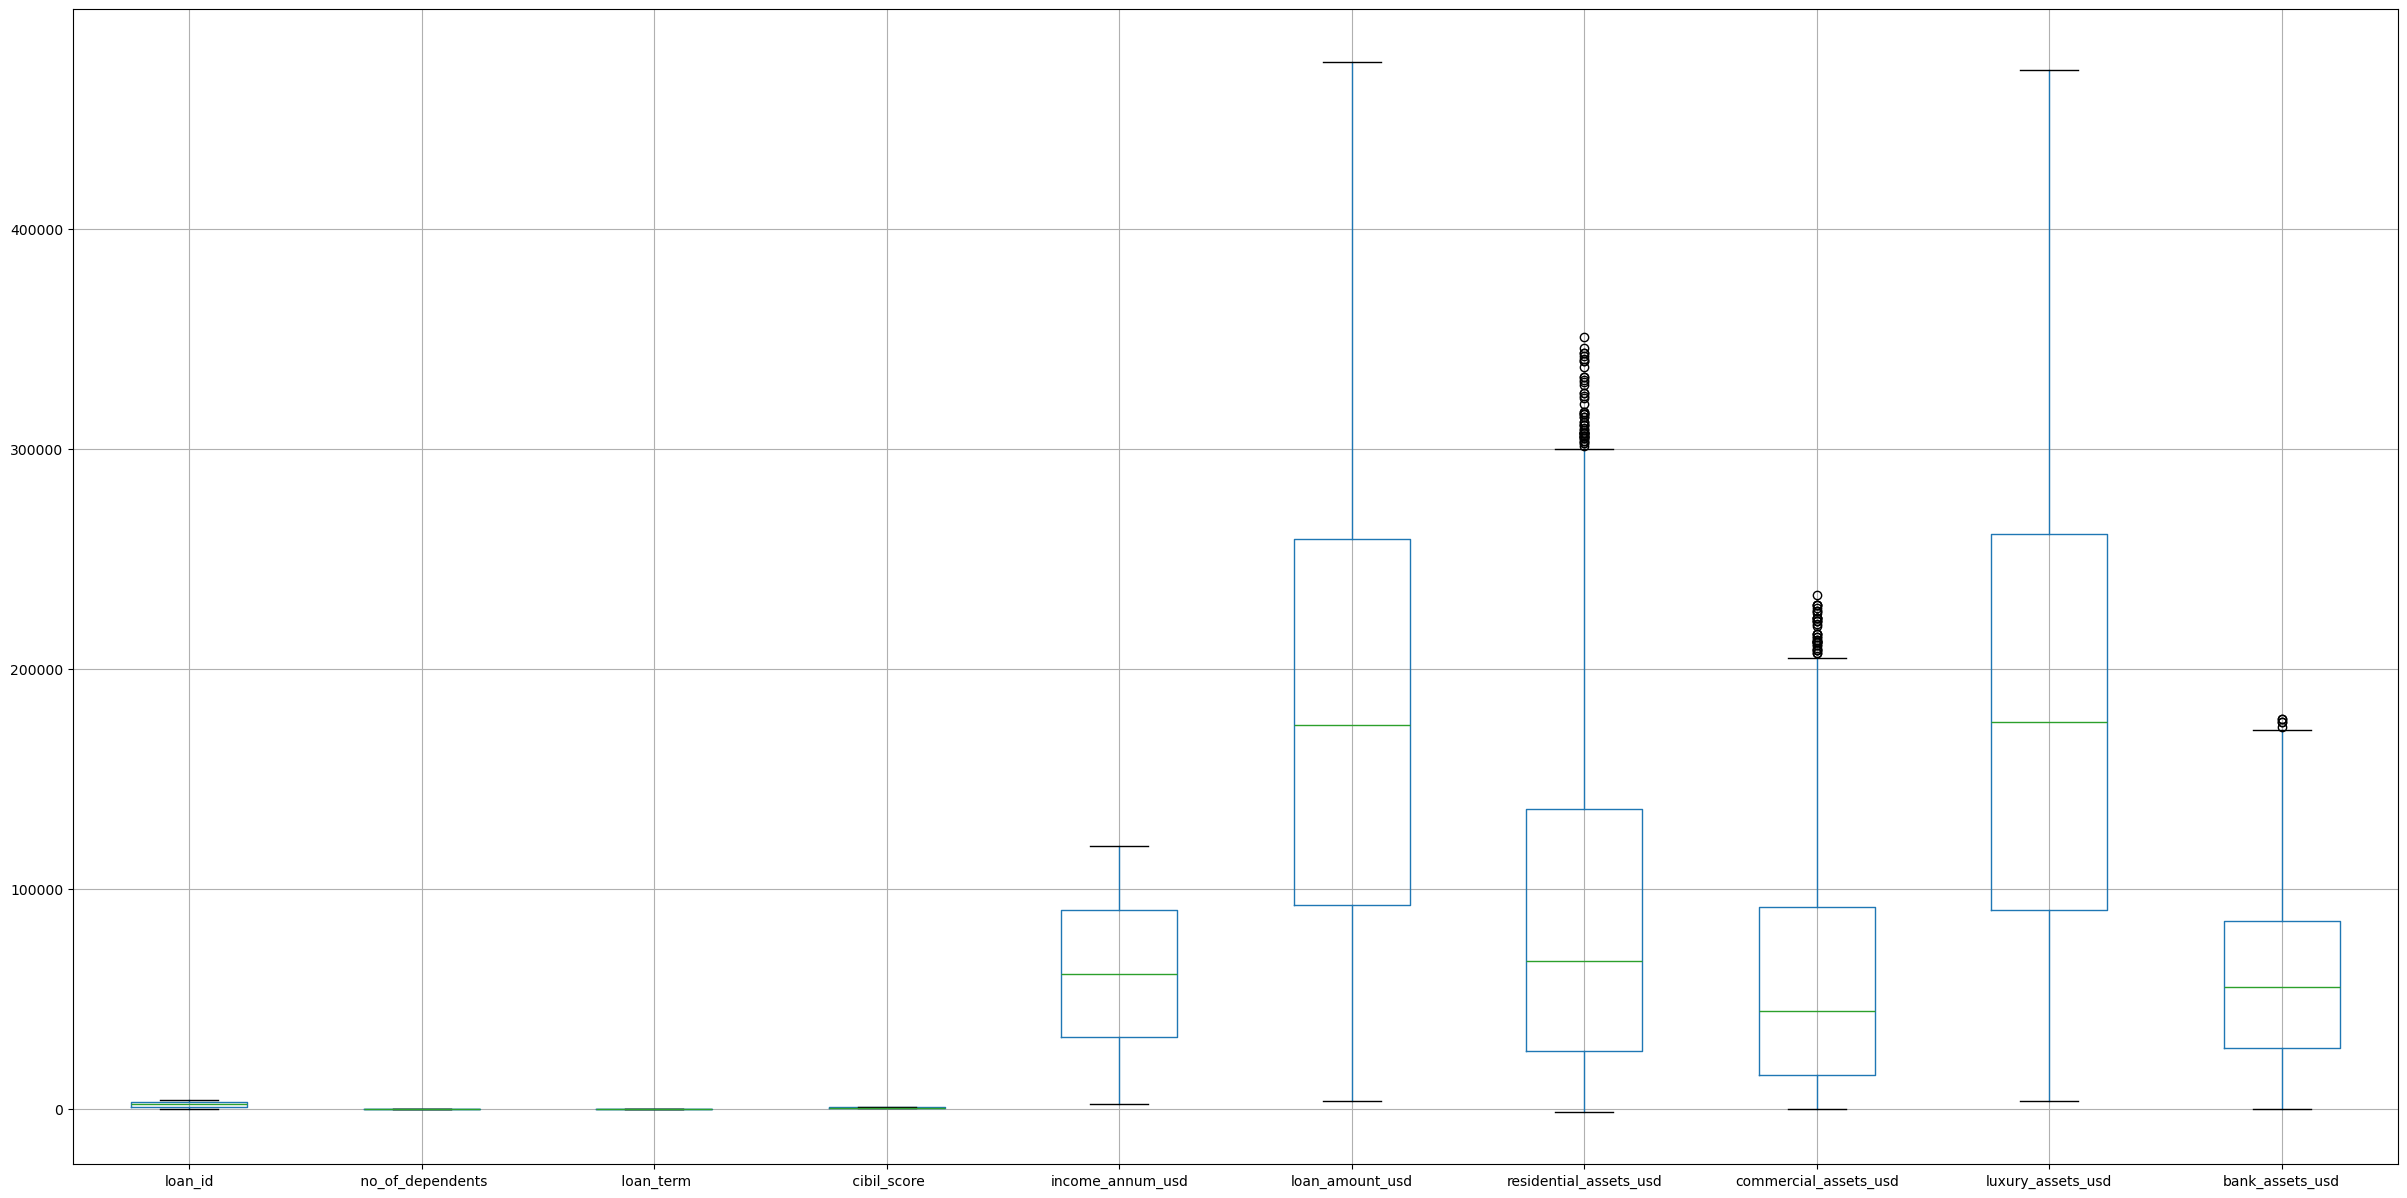

In [9]:
plt.figure(figsize=(30,15))
df.boxplot()
plt.show()

In [10]:
def outlie_processing(your_column):
    Q1 = df[your_column].quantile(0.25)
    Q3 = df[your_column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[your_column] < Q1 - 1.5 * IQR) | (df[your_column] > Q3 + 1.5 * IQR)][your_column]
    print(outliers)

outlie_processing('residential_assets_usd')
outlie_processing('commercial_assets_usd')
outlie_processing('bank_assets_usd')

82      307228.915663
98      312048.192771
123     322891.566265
228     307228.915663
262     308433.734940
693     306024.096386
714     340963.855422
781     316867.469880
892     332530.120482
905     345783.132530
919     304819.277108
924     310843.373494
953     307228.915663
956     304819.277108
987     339759.036145
997     303614.457831
1002    310843.373494
1397    309638.554217
1419    307228.915663
1468    325301.204819
1591    343373.493976
1625    316867.469880
1965    342168.674699
1997    325301.204819
2185    312048.192771
2318    343373.493976
2384    320481.927711
2412    315662.650602
2586    337349.397590
2715    310843.373494
2818    307228.915663
2828    324096.385542
2922    303614.457831
2927    332530.120482
2930    304819.277108
2940    314457.831325
3119    350602.409639
3157    306024.096386
3234    339759.036145
3310    302409.638554
3498    308433.734940
3631    306024.096386
3763    314457.831325
3782    331325.301205
3860    301204.819277
3868    30

In [11]:
df.describe()

,loan_id,no_of_dependents,loan_term,cibil_score,income_annum_usd,loan_amount_usd,residential_assets_usd,commercial_assets_usd,luxury_assets_usd,bank_assets_usd
count,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000,4269.000000
mean,2135.000000,2.498712,10.900445,599.936051,60953.300200,182330.728395,90031.524552,59917.533804,182244.649716,59960.149805
std,1232.498479,1.695910,5.709187,172.430401,33817.347371,108956.180540,78357.067321,52879.109514,109683.779099,39158.859105
min,1.000000,0.000000,2.000000,300.000000,2409.638554,3614.457831,-1204.819277,0.000000,3614.457831,0.000000
25%,1068.000000,1.000000,6.000000,453.000000,32530.120482,92771.084337,26506.024096,15662.650602,90361.445783,27710.843373
50%,2135.000000,3.000000,10.000000,600.000000,61445.783133,174698.795181,67469.879518,44578.313253,175903.614458,55421.686747
75%,3202.000000,4.000000,16.000000,748.000000,90361.445783,259036.144578,136144.578313,91566.265060,261445.783133,85542.168675
max,4269.000000,5.000000,20.000000,900.000000,119277.108434,475903.614458,350602.409639,233734.939759,472289.156627,177108.433735


Phát hiện 1 giá trị âm (-1204.819277) trong cột residential_assets_value. Đây là giá trị không hợp lệ vì tài sản không thể âm.

- Thay thế bằng trung vị của cột residential_assets_value

In [12]:
df[df['residential_assets_usd'] < 0]


,loan_id,no_of_dependents,education,self_employed,loan_term,cibil_score,loan_status,income_annum_usd,loan_amount_usd,residential_assets_usd,commercial_assets_usd,luxury_assets_usd,bank_assets_usd
59,60,4,Not Graduate,Yes,16,797,Approved,66265.060241,219277.108434,-1204.819277,59036.144578,224096.385542,57831.325301
196,197,4,Not Graduate,Yes,2,669,Approved,4819.277108,18072.289157,-1204.819277,7228.915663,10843.373494,6024.096386
559,560,2,Graduate,Yes,6,885,Rejected,2409.638554,6024.096386,-1204.819277,0.000000,3614.457831,2409.638554
702,703,4,Graduate,Yes,6,899,Approved,75903.614458,287951.807229,-1204.819277,137349.397590,248192.771084,80722.891566
737,738,2,Graduate,Yes,16,458,Rejected,10843.373494,30120.481928,-1204.819277,1204.819277,38554.216867,13253.012048
784,785,0,Graduate,No,2,761,Approved,60240.963855,173493.975904,-1204.819277,87951.807229,151807.228916,54216.867470
904,905,2,Graduate,No,12,571,Approved,49397.590361,179518.072289,-1204.819277,62650.602410,156626.506024,40963.855422
1089,1090,3,Graduate,No,6,336,Rejected,61445.783133,132530.120482,-1204.819277,69879.518072,139759.036145,90361.445783
1163,1164,2,Graduate,No,18,593,Approved,54216.867470,109638.554217,-1204.819277,7228.915663,149397.590361,30120.481928
1350,1351,5,Graduate,No,6,496,Rejected,48192.771084,165060.240964,-1204.819277,16867.469880,190361.445783,44578.313253


In [13]:
# Thay thế các giá trị âm trong cột residential_assets_usd bằng trung vị
median_residential_usd = df['residential_assets_usd'].median()
df.loc[df['residential_assets_usd'] < 0, 'residential_assets_usd'] = median_residential_usd

# Kiểm tra lại để đảm bảo không còn giá trị âm
print(df[df['residential_assets_usd'] < 0])

Empty DataFrame
Columns: [loan_id,  no_of_dependents,  education,  self_employed,  loan_term,  cibil_score,  loan_status, income_annum_usd, loan_amount_usd, residential_assets_usd, commercial_assets_usd, luxury_assets_usd, bank_assets_usd]
Index: []


## 2.2 Mã hóa biến phân loại

| Biến            | Giá trị gốc             | Sau mã hóa |
| --------------- | ----------------------- | ---------- |
| `education`     | Graduate / Not Graduate | 1 / 0      |
| `self_employed` | Yes / No                | 1 / 0      |
| `loan_status`   | Approved / Rejected     | 1 / 0      |


In [14]:
# Loại bỏ khoảng trắng ở tên cột
df.columns = df.columns.str.strip()

# Mã hóa các biến phân loại sau khi loại bỏ khoảng trắng dư thừa
df['education'] = df['education'].astype(str).str.strip().map({'Graduate': 1, 'Not Graduate': 0})
df['self_employed'] = df['self_employed'].astype(str).str.strip().map({'Yes': 1, 'No': 0})
df['loan_status'] = df['loan_status'].astype(str).str.strip().map({'Approved': 1, 'Rejected': 0})
df

,loan_id,no_of_dependents,education,self_employed,loan_term,cibil_score,loan_status,income_annum_usd,loan_amount_usd,residential_assets_usd,commercial_assets_usd,luxury_assets_usd,bank_assets_usd
0,1,2,1,0,12,778,1,115662.650602,360240.963855,28915.662651,212048.192771,273493.975904,96385.542169
1,2,0,0,1,8,417,0,49397.590361,146987.951807,32530.120482,26506.024096,106024.096386,39759.036145
2,3,3,1,0,20,506,0,109638.554217,357831.325301,85542.168675,54216.867470,401204.819277,154216.867470
3,4,3,1,0,8,467,0,98795.180723,369879.518072,219277.108434,39759.036145,280722.891566,95180.722892
4,5,5,0,1,20,382,0,118072.289157,291566.265060,149397.590361,98795.180723,354216.867470,60240.963855
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,4265,5,1,1,12,317,0,12048.192771,27710.843373,33734.939759,6024.096386,39759.036145,9638.554217
4265,4266,0,0,1,20,559,1,39759.036145,136144.578313,50602.409639,34939.759036,132530.120482,22891.566265
4266,4267,2,0,0,18,457,0,78313.253012,287951.807229,14457.831325,149397.590361,218072.289157,87951.807229
4267,4268,1,0,0,8,780,1,49397.590361,154216.867470,98795.180723,8433.734940,169879.518072,69879.518072


## 2.3 Chuẩn hóa dữ liệu số

In [15]:
from sklearn.preprocessing import StandardScaler

# Các cột cần chuẩn hóa
cols_to_scale = [
    'income_annum_usd', 'loan_amount_usd', 'loan_term', 'cibil_score',
    'residential_assets_usd', 'commercial_assets_usd', 'luxury_assets_usd', 'bank_assets_usd'
]

scaler = StandardScaler()
df_zscore = df.copy()
df_zscore[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

df_zscore.head()

,loan_id,no_of_dependents,education,self_employed,loan_term,cibil_score,loan_status,income_annum_usd,loan_amount_usd,residential_assets_usd,commercial_assets_usd,luxury_assets_usd,bank_assets_usd
0,1,2,1,0,0.192617,1.032792,1,1.617979,1.633052,-0.789121,2.877289,0.832028,0.930304
1,2,0,0,1,-0.508091,-1.061051,0,-0.341750,-0.324414,-0.742793,-0.631921,-0.694993,-0.515936
2,3,3,1,0,1.594031,-0.544840,0,1.439822,1.610933,-0.063315,-0.107818,1.996520,2.407316
3,4,3,1,0,-0.508091,-0.771045,0,1.119139,1.721525,1.650822,-0.381263,0.897943,0.899533
4,5,5,0,1,1.594031,-1.264055,0,1.689242,1.002681,0.755147,0.735304,1.568075,0.007172


## 2.3. Trực quan hóa dữ liệu

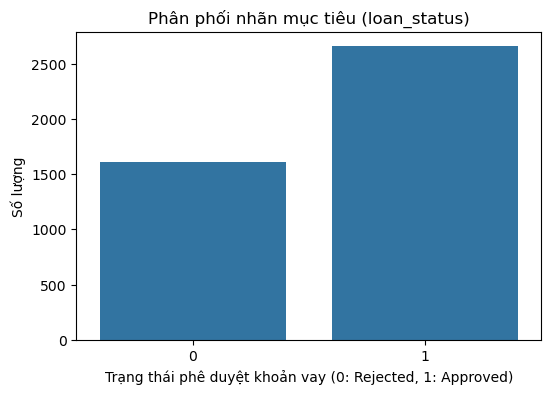

In [16]:
# Trực quan hóa phân phối nhãn mục tiêu (loan_status)
plt.figure(figsize=(6,4))
sb.countplot(x='loan_status', data=df)
plt.title('Phân phối nhãn mục tiêu (loan_status)')
plt.xlabel('Trạng thái phê duyệt khoản vay (0: Rejected, 1: Approved)')
plt.ylabel('Số lượng')
plt.show()

Chênh lệnh dữ liệu không quá cao chỉ khoảng 40-60 

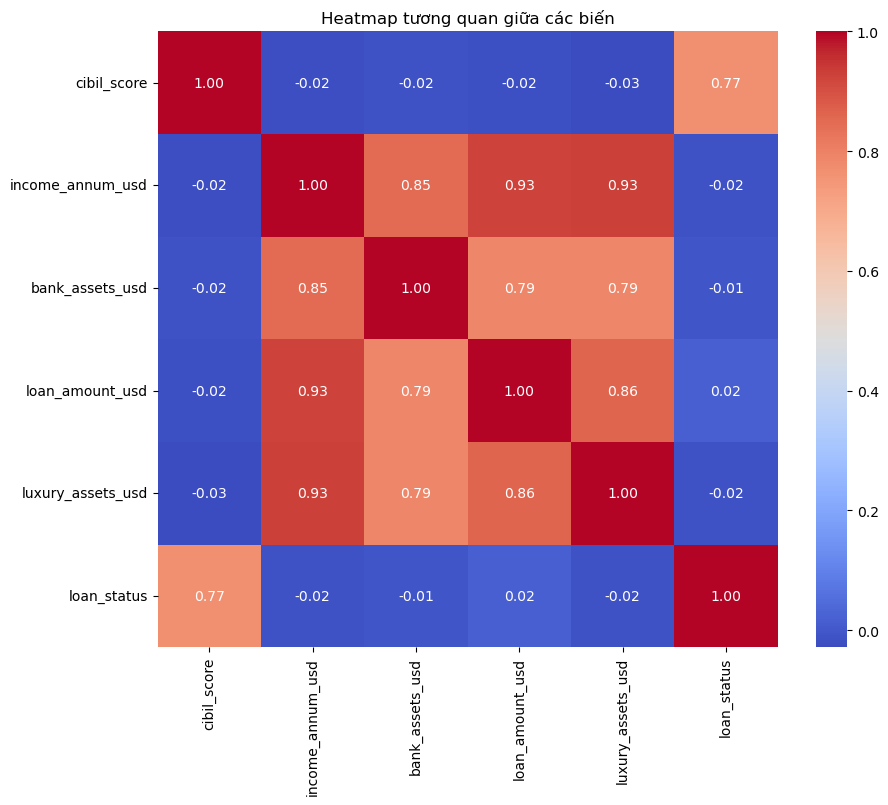

In [17]:
# Heatmap tương quan giữa các biến
plt.figure(figsize=(10, 8))
corr = df[['cibil_score', 'income_annum_usd', 'bank_assets_usd', 'loan_amount_usd', 'luxury_assets_usd', 'loan_status']].corr()
sb.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap tương quan giữa các biến')
plt.show()

cibil_score có tương quan cao nhất với loan_status (hệ số 0.77). Đây là biến quan trọng nhất ảnh hưởng đến việc khoản vay được phê duyệt.

Các biến tài chính khác như income_annum_usd, loan_amount_usd, luxury_assets_usd, bank_assets_usd có tương quan rất thấp với loan_status (gần 0). Điều này cho thấy thu nhập và giá trị tài sản không phải là yếu tố quyết định rõ ràng đến kết quả xét duyệt.

Trong khi đó, các biến tài chính này có tương quan mạnh với nhau (từ 0.79 đến 0.93), phản ánh rằng người có thu nhập cao thường vay nhiều hơn và sở hữu nhiều tài sản hơn.

# 3. Huấn Luyện Mô Hình

## 3.1. Chia train/test

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Tách X và y
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Chuẩn hóa biến số
cont_cols = ['cibil_score','income_annum_usd','loan_amount_usd',
             'residential_assets_usd','commercial_assets_usd',
             'luxury_assets_usd','bank_assets_usd']
scaler = StandardScaler()
X[cont_cols] = scaler.fit_transform(X[cont_cols])

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [20]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
# XGBoost Classifier
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [22]:
# SVM Classifier
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)

SVC(probability=True, random_state=42)

# 5. Grid Search tối ưu tham số

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'RandomForest': {'n_estimators':[50,100],
                     'max_depth':[None,5,10]},

    'XGBoost': {'n_estimators':[50,100],
                'max_depth':[3,5],
                'learning_rate':[0.1,0.01]},

    # 'SVM': {'C':[0.1,1,10],
    #         'kernel':['linear','rbf'],
    #         'gamma':['scale','auto']}
}

#models = {'RandomForest':rf,'XGBoost':xgb,'SVM':svm}
models = {'RandomForest':rf,'XGBoost':xgb}
best_models = {}
for name, model in models.items():
    gs = GridSearchCV(model, param_grid[name], cv=3, scoring='f1', n_jobs=-1)
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    print(f"{name} best params:", gs.best_params_)


RandomForest best params: {'max_depth': None, 'n_estimators': 100}
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


# 6. So sánh hiệu năng

In [24]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

results = {}
for name, m in best_models.items():
    y_pred = m.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test,y_pred),
        'Precision': precision_score(y_test,y_pred),
        'Recall': recall_score(y_test,y_pred),
        'F1': f1_score(y_test,y_pred)
    }

import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)

              Accuracy  Precision    Recall        F1
RandomForest  0.979703   0.988593  0.978670  0.983607
XGBoost       0.983607   0.985000  0.988708  0.986850


<Figure size 600x400 with 0 Axes>

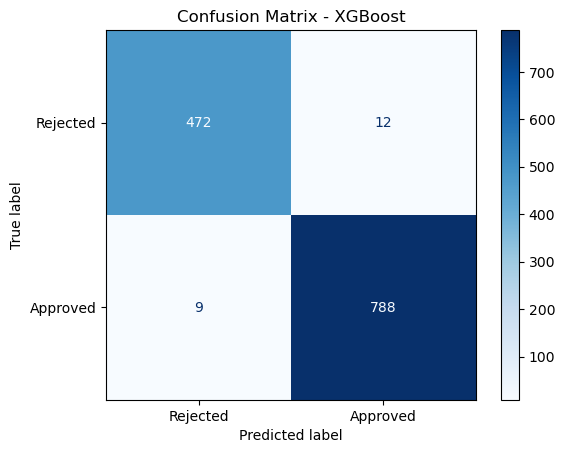

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Trực quan hóa ma trận nhầm lẫn cho mô hình XGBoost

# Dự đoán trên tập test với XGBoost
y_pred_xgb = best_models['XGBoost'].predict(X_test)

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Rejected', 'Approved'])

plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# 6.1 Phân tích mức độ quan trọng của đặc trưng (Feature Importance)

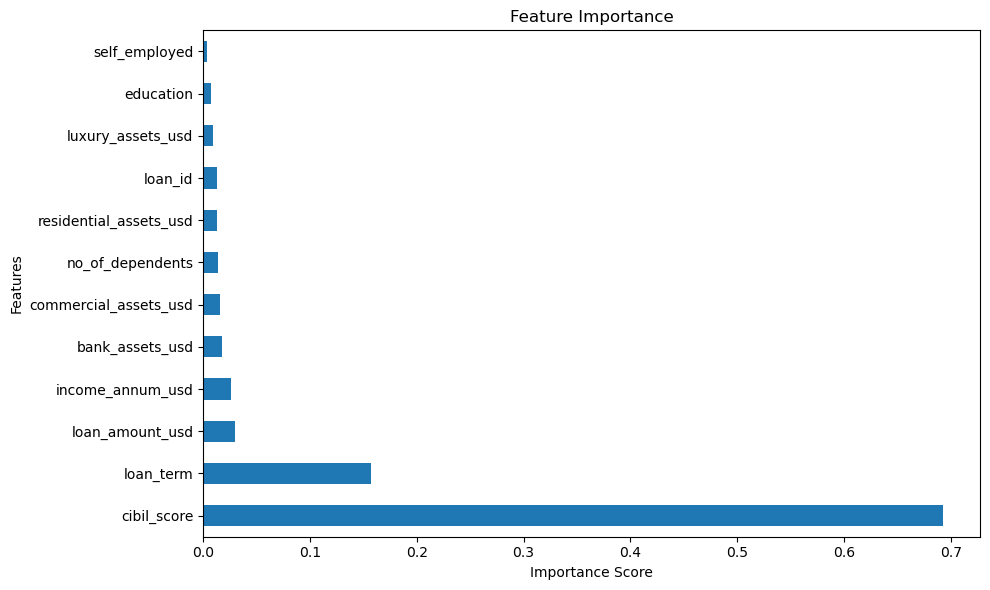

In [26]:
# Lấy mô hình tốt nhất (XGBoost có F1 cao nhất)
model = best_models[results_df['F1'].idxmax()]
importances = model.feature_importances_

# Tạo bảng và biểu đồ
feat_imp = pd.Series(importances, index=X_test.columns).sort_values(ascending=False)
feat_imp.plot(kind='barh', figsize=(10,6), title='Feature Importance')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [27]:
print("Top 5 biến quan trọng nhất (theo mô hình tốt nhất):")
top5 = feat_imp.head(5)
display(top5)

Top 5 biến quan trọng nhất (theo mô hình tốt nhất):


cibil_score         0.692766
loan_term           0.156953
loan_amount_usd     0.029988
income_annum_usd    0.026232
bank_assets_usd     0.017595
dtype: float32

# 7. Phân nhóm khách hàng hỗ trợ ra quyết định
---
Dựa trên xác suất dự đoán từ mô hình có F1 cao nhất, ta phân loại khách hàng thành 3 nhóm:
- Xác suất ≥ 80%: tự động duyệt (rủi ro thấp).
- Xác suất 20%–80%: cần thẩm định thủ công (rủi ro trung bình).
- Xác suất < 20%: tự động từ chối (rủi ro cao).

Tại sao phải dựa trên xác suất dự đoán từ mô hình có F1 cao nhất?
- F1-score là chỉ số tổng hợp giữa Precision và Recall, rất phù hợp khi dữ liệu có mất cân bằng hoặc khi bạn muốn cân bằng giữa việc phát hiện đúng khách được duyệt và tránh duyệt nhầm khách rủi ro.
- Khi so sánh nhiều mô hình (Random Forest, XGBoost, SVM), bạn nên chọn mô hình có F1-score cao nhất vì nó cho thấy mô hình đó dự đoán tốt nhất tổng thể cho cả hai lớp (Approved và Rejected).
- Xác suất dự đoán từ mô hình tốt nhất này sẽ đáng tin cậy nhất để phân loại khách hàng thành các nhóm hành động (tự động duyệt, thẩm định, từ chối).

In [28]:
# Xác suất dự đoán
probs = best_models[results_df['F1'].idxmax()].predict_proba(X_test)[:,1] # xác suất lớp 1 (Approved)

group = pd.cut(probs, bins=[0,0.2,0.8,1], labels=[
    'Auto Reject','Manual Review','Auto Approve'])

print(group.value_counts())
decisions = pd.DataFrame({
    'Probability':probs,
    'Decision':group
}, index=y_test.index)



Auto Reject      451
Manual Review     62
Auto Approve     768
Name: count, dtype: int64


In [29]:
print("Quyết định dựa trên xác suất:")
display(decisions.head(5))


Quyết định dựa trên xác suất:


,Probability,Decision
2924,0.003289,Auto Reject
4113,0.998593,Auto Approve
1960,0.995160,Auto Approve
1634,0.999475,Auto Approve
871,0.722200,Manual Review
